In [138]:
import re
import random
import pandas as pd
import hashlib

In [139]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [140]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,364.762595,40.529177,61.881177,9
DAX,565.248449,62.805383,144.368691,9
CCH Axcess,584.325504,20.149155,38.456000,29
Azure Private DNS,837.576060,93.064007,196.077947,9
Terraform,1097.319490,91.443291,273.852954,12
Azure AD Authentication,1238.235416,103.186285,165.277378,12
Azure Functions + PP365,1460.518805,91.282425,249.054328,16
Microsoft Purview,1621.548913,33.782269,51.023254,48
TSQL,1650.491391,68.770475,169.379806,24
Azure DevOps Pipelines,1703.027584,106.439224,294.352171,16


# Histogram

sum of ages: ~54005.21


<Axes: >

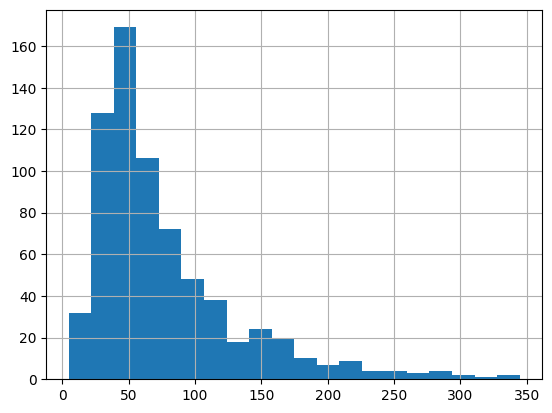

In [141]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54005.21


<Axes: >

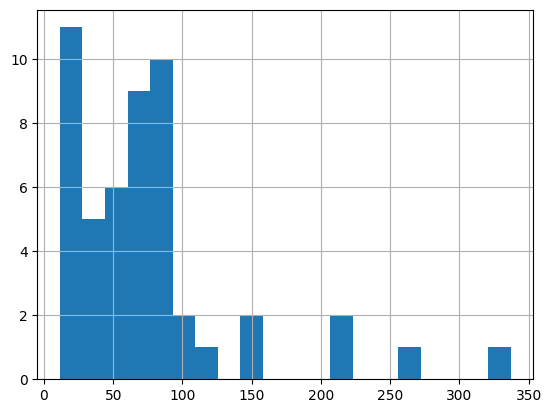

In [142]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [143]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [144]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [145]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [146]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [147]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [148]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [149]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [150]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [151]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [152]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 701
Total card age: 54005.21


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
97,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,344.774905,96.381585,-344.774905,2891.447552,0.516122,30,0,0,-344.774905
100,C# Basics,How do nullable types work in C#?\n\nC#: Nulla...,532c385eaaaa1b24460122c964e8af1d,161.301354,96.381585,-344.774905,2891.447552,0.516122,30,3,0,-161.301354
103,C# Basics,Extension methods allow you to add functionali...,c5d7d65fff7b02663aa8f6f707626498,117.139258,96.381585,-344.774905,2891.447552,0.516122,30,6,0,-117.139258
105,C# Basics,How do you write an if-statement in C#?\n\nC#:...,a59cd584a190a33edc7a95c059362ed6,108.356847,96.381585,-344.774905,2891.447552,0.516122,30,9,0,-108.356847
265,C# Basics,What is the basic syntax for declaring a varia...,e7d19b61bb9ff0dd17e129dcd89e6a7d,87.547914,96.381585,-344.774905,2891.447552,0.516122,30,12,0,-87.547914
268,C# Basics,A constructor is a special method used to init...,cff83ac94df0a7e5f6ce64eb8d98220d,82.890608,96.381585,-344.774905,2891.447552,0.516122,30,15,0,-82.890608
271,C# Basics,What are the key access modifiers in C#?\n\npu...,bd09423f2706aac94103024c01fb433a,66.004646,96.381585,-344.774905,2891.447552,0.516122,30,18,0,-66.004646
404,C# Basics,What is the syntax for a for loop in C#?\n\nC#...,b007dd02bc671a50d0e254dd81f8dbee,59.898691,96.381585,-344.774905,2891.447552,0.516122,30,21,0,-59.898691
406,C# Basics,"Generics allow you to define classes, methods,...",acfafce93b119c7da5787b1e8f379860,55.616990,96.381585,-344.774905,2891.447552,0.516122,30,24,0,-55.616990
409,C# Basics,"C#: Delegates are type-safe function pointers,...",09087e1f0b7050d2f913fb04e5a34db9,49.460365,96.381585,-344.774905,2891.447552,0.516122,30,27,0,-49.460365


## Card Count

In [153]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [154]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [155]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
97,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,344.774905,96.381585,-344.774905,2891.447552,0.516122,30,0,0,-344.774905
177,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,337.091240,75.788939,-337.091240,3789.446952,0.741505,50,0,0,-337.091240
107,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,310.825663,94.902569,-310.825663,2941.979625,0.822908,31,0,0,-310.825663
147,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,297.128222,95.227188,-297.128222,3618.633129,0.207715,38,0,0,-297.128222
57,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,294.352171,106.439224,-294.352171,1703.027584,0.571065,16,0,0,-294.352171
58,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,290.530342,106.439224,-294.352171,1703.027584,0.571065,16,1,1,-290.530342
148,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,287.100122,95.227188,-297.128222,3618.633129,0.207715,38,1,1,-287.100122
187,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,286.344687,62.896912,-286.344687,3333.536323,0.110978,53,0,0,-286.344687
77,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,281.445067,98.292181,-281.445067,2653.888891,0.956205,27,0,0,-281.445067
37,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,273.852954,91.443291,-273.852954,1097.319490,0.544435,12,0,0,-273.852954


In [156]:
existing_cards['age'].mean()

77.04024275084114